In [6]:
import getpass
import pandas as pd
import numpy as np
import matplotlib as mplot
import urllib.parse
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Markdown as md
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import plotly.express as px
import pytz

pd.set_option('display.max_columns', None)

In [ ]:
edm_address = ""# getpass.getpass(prompt='EDM server address: ')
print(edm_address)
print('\nEDM login information')
edm_name = ""#getpass.getpass(prompt='Username: ')
edm_password = getpass.getpass(prompt='Password: ')
edm_password = urllib.parse.quote(edm_password)
%load_ext sql
%sql postgresql://$edm_name:$edm_password@$edm_address/edm
%config SqlMagic.displaycon = False
%config SqlMagic.feedback = False
print(edm_name, edm_password)
# Delete the credential variables for security purpose.
del edm_name, edm_password



EDM login information


Past Month Loads:
  phases  total_kwh
0      C   46371.86
1      B  132162.12
2      A  200022.75


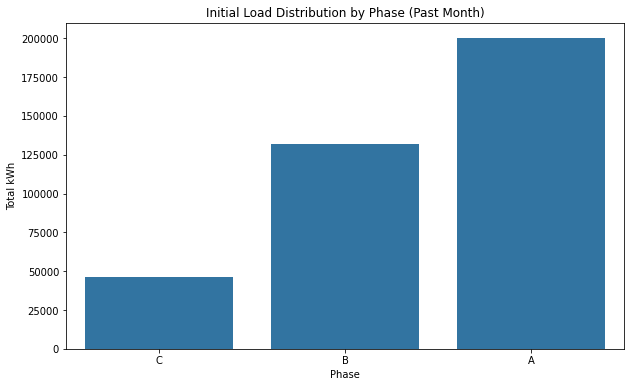

Meter Counts per Phase:
  phases  meter_count
0      C           40
1      B          110
2      A          166
Actual Loads:
 phases
C     46371.86
B    132162.12
A    200022.75
Name: total_kwh, dtype: float64
Optimal load for phase C: 126185.58
Optimal load for phase B: 126185.58
Optimal load for phase A: 126185.58


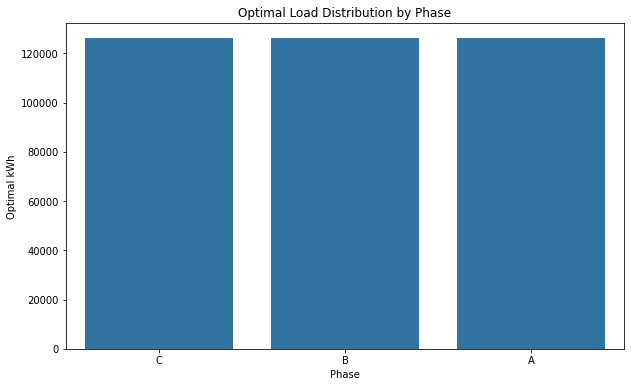

Load Differences:
 phases
C   -79813.72
B     5976.54
A    73837.17
dtype: float64
Meters Result:
   phases    meter_id  total_kwh
0      A    17FY28-2     446.06
1      A  17Y124-3-3     505.82
2      A   17F1Y24-2     549.66
3      A     17F1Y27     556.81
4      A     17Y12-X     584.13
5      A      17BY14     588.39
6      A   17F1Y29-2     589.42
7      A     17B1Y12     591.41
8      A    17Y163-B     598.68
9      A   17F1Y25-7     601.00
Reassign meter 17AY44-1ZA from phase B to phase C with load 3128.55
Reassign meter 17AY38 from phase B to phase C with load 3046.12
Reassign meter 17BY3-1 from phase A to phase C with load 8129.49
Reassign meter 17Y172X from phase A to phase C with load 2642.85
Reassign meter 17FY19 from phase A to phase C with load 2399.53
Reassign meter 17Y125 from phase A to phase B with load 2019.89
Improvement: 38693.07999999999, Previous total diff: 159627.43, Current total diff: 120934.35
Reassign meter 17Y34-B from phase B to phase C with load 2025.96


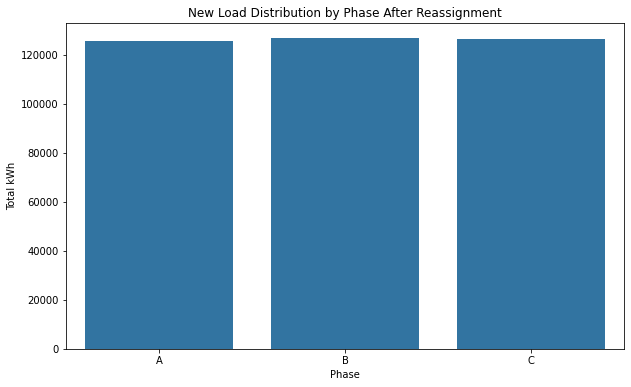

In [3]:
#Monthly
from pulp import LpMinimize, LpProblem, LpVariable, lpSum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta

#GRID
grid_id = 'North Central Zone'
grid_element_id = '12373_hvmv'
end_date = '2023-01-01 00:00:00'

#TIME
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S').replace(microsecond=0, second=0, minute=0)
end_date = pytz.timezone('America/Vancouver').localize(end_date)


past_month = end_date - relativedelta(months=1)
timerange_month = f'[ {past_month} , {end_date} ]'

# SQL Query to aggregate at the phase level for past month
query_phases_month = f"""
SELECT ggd.phases,
    ROUND(CAST(SUM(tdss_c.value - COALESCE(tdss_p.value, 0)) AS NUMERIC), 2) as "total_kWh"
FROM grid_element ge
JOIN grid_get_downstream('{grid_id}', ge.grid_element_id, 'false') ggd
    ON ggd.grid_id = ge.grid_id 
JOIN grid_element_data_source geds_c 
    ON geds_c.grid_element_id = ggd.grid_element_id 
        AND geds_c.type = 'CONSUMER' 
JOIN ts_data_source_select(geds_c.grid_element_data_source_id, 'kWh', '{timerange_month}') tdss_c 
    ON true 
LEFT JOIN grid_element_data_source geds_p 
    ON geds_p.grid_element_id = geds_c.grid_element_id 
        AND geds_p.type = 'PRODUCER' 
LEFT JOIN ts_data_source_select(geds_p.grid_element_data_source_id, 'kWh', '{timerange_month}') tdss_p 
    ON tdss_p.timestamp = tdss_c.timestamp 
WHERE ge.grid_element_id = '{grid_element_id}' 
    AND ggd.type = 'Meter' 
GROUP BY ggd.phases
ORDER by 2;
"""


result_phases_month = get_ipython().run_line_magic('sql', '$query_phases_month')
df_phases_month = result_phases_month.DataFrame()


print("Past Month Loads:")
print(df_phases_month)

# Plot 
plt.figure(figsize=(10, 6))
sns.barplot(x='phases', y='total_kwh', data=df_phases_month)
plt.title('Initial Load Distribution by Phase (Past Month)')
plt.xlabel('Phase')
plt.ylabel('Total kWh')
plt.savefig('initial_load_distribution_month.png')  # Save the plot
plt.show()

# Count the total number of meters downstream and group by phase
query_meter_counts = f"""
SELECT ggd.phases,
    COUNT(ggd.grid_element_id) as meter_count
FROM grid_element ge
JOIN grid_get_downstream('{grid_id}', ge.grid_element_id, 'false') ggd
    ON ggd.grid_id = ge.grid_id 
WHERE ge.grid_element_id = '{grid_element_id}' 
    AND ggd.type = 'Meter' 
GROUP BY ggd.phases
ORDER BY 2;
"""


result_meter_counts = get_ipython().run_line_magic('sql', '$query_meter_counts')
df_meter_counts = result_meter_counts.DataFrame()


print("Meter Counts per Phase:")
print(df_meter_counts)

# Combine meter counts with total kWh
df_phases_result = pd.merge(df_phases_month, df_meter_counts, on='phases')

# Calculate the actual load for each phase
actual_loads = df_phases_result.set_index('phases')['total_kwh'].astype(float)
print("Actual Loads:\n", actual_loads)

# LP problem
prob = LpProblem("PhaseBalance", LpMinimize)


phase_loads = {phase: LpVariable(f"Load_{phase}", 0) for phase in actual_loads.index}


abs_diff = {(phase, other_phase): LpVariable(f"AbsDiff_{phase}_{other_phase}", 0) 
            for phase in actual_loads.index for other_phase in actual_loads.index if phase != other_phase}

# Objective: Minimize the sum of absolute differences between phases
prob += lpSum(abs_diff.values())

# Constraints: Total load must remain constant
total_load = actual_loads.sum()
prob += lpSum(phase_loads.values()) == total_load

# Constraints for absolute differences and balancing
average_load = total_load / len(actual_loads)
for phase in actual_loads.index:
    prob += phase_loads[phase] <= average_load + 10  # Adjust tolerance as needed
    prob += phase_loads[phase] >= average_load - 10


for phase in actual_loads.index:
    for other_phase in actual_loads.index:
        if phase != other_phase:
            prob += abs_diff[(phase, other_phase)] >= phase_loads[phase] - phase_loads[other_phase]
            prob += abs_diff[(phase, other_phase)] >= phase_loads[other_phase] - phase_loads[phase]


prob.solve()


optimal_loads = {phase: phase_loads[phase].value() for phase in phase_loads}
for phase, load in optimal_loads.items():
    print(f"Optimal load for phase {phase}: {load}")

# DataFrame for the optimal loads
optimal_loads_df = pd.DataFrame({
    'phase': list(optimal_loads.keys()),
    'optimal_load': list(optimal_loads.values())
})

# Plot 
plt.figure(figsize=(10, 6))
sns.barplot(x='phase', y='optimal_load', data=optimal_loads_df)
plt.title('Optimal Load Distribution by Phase')
plt.xlabel('Phase')
plt.ylabel('Optimal kWh')
plt.savefig('optimal_load_distribution.png')  
plt.show()


optimal_loads_df.set_index('phase', inplace=True)

# Calculate the difference between actual and optimal loads
optimal_loads_df['optimal_load'] = optimal_loads_df['optimal_load'].astype(float)
load_diff = actual_loads - optimal_loads_df['optimal_load']
print("Load Differences:\n", load_diff)

# SQL Query to get detailed meter data for the selected time range (past month)
query_meters = f"""
SELECT ggd.phases,
    ggd.grid_element_id as meter_id,
    ROUND(CAST(SUM(tdss_c.value - COALESCE(tdss_p.value, 0)) AS NUMERIC), 2) as "total_kWh"
FROM grid_element ge
JOIN grid_get_downstream('{grid_id}', ge.grid_element_id, 'false') ggd
    ON ggd.grid_id = ge.grid_id 
JOIN grid_element_data_source geds_c 
    ON geds_c.grid_element_id = ggd.grid_element_id 
        AND geds_c.type = 'CONSUMER' 
JOIN ts_data_source_select(geds_c.grid_element_data_source_id, 'kWh', '{timerange_month}') tdss_c 
    ON true 
LEFT JOIN grid_element_data_source geds_p 
    ON geds_p.grid_element_id = geds_c.grid_element_id 
        AND geds_p.type = 'PRODUCER' 
LEFT JOIN ts_data_source_select(geds_p.grid_element_data_source_id, 'kWh', '{timerange_month}') tdss_p 
    ON tdss_p.timestamp = tdss_c.timestamp 
WHERE ge.grid_element_id = '{grid_element_id}' 
    AND ggd.type = 'Meter' 
GROUP BY ggd.phases, ggd.grid_element_id
ORDER by ggd.phases, 3;
"""


result_meters = get_ipython().run_line_magic('sql', '$query_meters')
df_meters_result = result_meters.DataFrame()


df_meters_result['total_kwh'] = df_meters_result['total_kwh'].astype(float)
print("Meters Result:\n", df_meters_result.head(10))

# Identify meters to reassign
def get_high_load_meters(phase, n=1):
    """Return n highest load meters from the specified phase."""
    return df_meters_result[df_meters_result['phases'] == phase].sort_values(by='total_kwh', ascending=False).head(n)

# Reassignment strategy: move highest load meters from overloaded phases to underloaded ones
def reassign_meters():
    global load_diff
    reassignment_count = 0
    meter_change_count = 0  
    max_reassignment_attempts = 1000 
    improvement_threshold = 0.001  
    tolerance_range = 100

    previous_total_diff = load_diff.abs().sum()
    reassigned_meters = set()  

    while any(load_diff.abs() > tolerance_range) and reassignment_count < max_reassignment_attempts:
        improvement = 0  
        for phase in load_diff.index:
            if load_diff[phase] > tolerance_range:  
                underloaded_phases = load_diff[load_diff < -tolerance_range].index.tolist()
                for underloaded_phase in underloaded_phases:
                    high_load_meters = get_high_load_meters(phase, n=3)  # Consider top 3 highest load meters
                    for index, row in high_load_meters.iterrows():
                        if row['meter_id'] in reassigned_meters:
                            continue  # Skip already reassigned meters

                        
                        potential_improvement = min(load_diff[phase], -load_diff[underloaded_phase], row['total_kwh'])

                      
                        if potential_improvement <= 0:
                            continue

                       
                        df_meters_result.loc[df_meters_result['meter_id'] == row['meter_id'], 'phases'] = underloaded_phase
                        reassigned_meters.add(row['meter_id'])  
                        print(f"Reassign meter {row['meter_id']} from phase {phase} to phase {underloaded_phase} with load {row['total_kwh']}")

                        
                        load_diff[phase] -= row['total_kwh']
                        load_diff[underloaded_phase] += row['total_kwh']
                        reassignment_count += 1
                        meter_change_count += 1  
                        improvement += potential_improvement 
                        if load_diff[underloaded_phase] >= 0:  
                            break
                    if load_diff[phase] <= 0: 
                        break
        
        current_total_diff = load_diff.abs().sum()
        improvement = previous_total_diff - current_total_diff
        print(f"Improvement: {improvement}, Previous total diff: {previous_total_diff}, Current total diff: {current_total_diff}")
        
        if improvement < improvement_threshold:  # Stop if the improvement is below the threshold
            print("Improvement below threshold. Stopping reassignments.")
            break

        previous_total_diff = current_total_diff

    print(f"Total meter changes: {meter_change_count}")


reassign_meters()


print("Updated Load Differences:\n", load_diff)
print("Updated Meters Result:\n", df_meters_result.head(10))


new_loads = df_meters_result.groupby('phases')['total_kwh'].sum().astype(float)
print("New Loads:\n", new_loads)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=new_loads.index, y=new_loads.values)
plt.title('New Load Distribution by Phase After Reassignment')
plt.xlabel('Phase')
plt.ylabel('Total kWh')
plt.savefig('new_load_distribution_after_reassignment.png')  
plt.show()


Past Year Loads:
  phases   total_kwh
0      C   619289.97
1      B  1743451.96
2      A  2631333.47


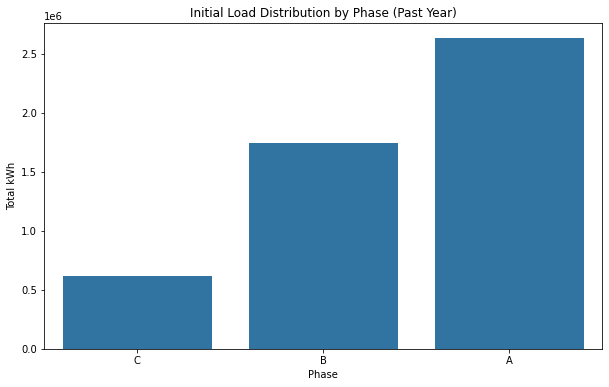

Meter Counts per Phase:
  phases  meter_count
0      C           40
1      B          110
2      A          166
Actual Loads:
 phases
C     619289.97
B    1743451.96
A    2631333.47
Name: total_kwh, dtype: float64
Optimal load for phase C: 1664691.8
Optimal load for phase B: 1664691.8
Optimal load for phase A: 1664691.8


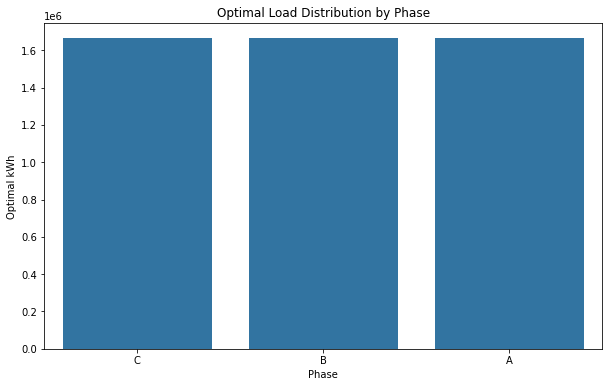

Load Differences:
 phases
C   -1045401.83
B      78760.16
A     966641.67
dtype: float64
Meters Result:
   phases    meter_id  total_kwh
0      A  17Y124-3-3    6554.27
1      A    17FY28-2    6688.05
2      A      17BY14    7615.82
3      A     17Y12-X    7630.17
4      A      17BY11    7633.00
5      A     17B1Y12    7705.33
6      A    17Y163-B    7751.39
7      A   17Y160CZA    7814.20
8      A   17F1Y25-7    7889.67
9      A     17Y118X    8582.02
Reassign meter 17AY44-1ZA from phase B to phase C with load 37967.93
Reassign meter 17AY38 from phase B to phase C with load 37028.26
Reassign meter 17Y34-B from phase B to phase C with load 26753.62
Reassign meter 17BY3-1 from phase A to phase C with load 98803.15
Reassign meter 17Y172X from phase A to phase C with load 31943.15
Reassign meter 17FY19 from phase A to phase C with load 29143.87
Reassign meter 17Y125 from phase A to phase B with load 25993.15
Improvement: 523279.9600000002, Previous total diff: 2090803.6600000001, Current 

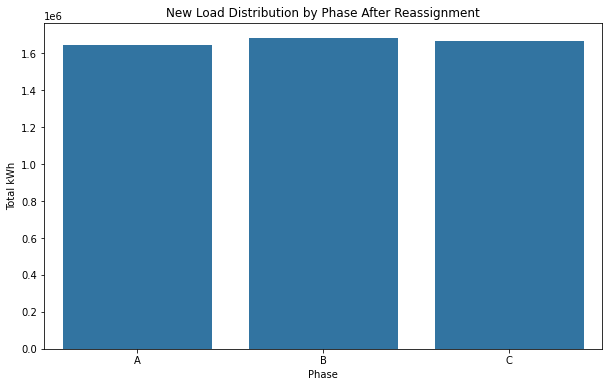

In [4]:
#YEARLY
from pulp import LpMinimize, LpProblem, LpVariable, lpSum
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta

#GRID
grid_id = 'North Central Zone'
grid_element_id = '12373_hvmv'
end_date = '2023-01-01 00:00:00'

#TIME
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S').replace(microsecond=0, second=0, minute=0)
end_date = pytz.timezone('America/Vancouver').localize(end_date)


past_year = end_date - relativedelta(years=1)
timerange_year = f'[ {past_year} , {end_date} ]'

# SQL Query to aggregate at the phase level for past year
query_phases_year = f"""
SELECT ggd.phases,
    ROUND(CAST(SUM(tdss_c.value - COALESCE(tdss_p.value, 0)) AS NUMERIC), 2) as "total_kWh"
FROM grid_element ge
JOIN grid_get_downstream('{grid_id}', ge.grid_element_id, 'false') ggd
    ON ggd.grid_id = ge.grid_id 
JOIN grid_element_data_source geds_c 
    ON geds_c.grid_element_id = ggd.grid_element_id 
        AND geds_c.type = 'CONSUMER' 
JOIN ts_data_source_select(geds_c.grid_element_data_source_id, 'kWh', '{timerange_year}') tdss_c 
    ON true 
LEFT JOIN grid_element_data_source geds_p 
    ON geds_p.grid_element_id = geds_c.grid_element_id 
        AND geds_p.type = 'PRODUCER' 
LEFT JOIN ts_data_source_select(geds_p.grid_element_data_source_id, 'kWh', '{timerange_year}') tdss_p 
    ON tdss_p.timestamp = tdss_c.timestamp 
WHERE ge.grid_element_id = '{grid_element_id}' 
    AND ggd.type = 'Meter' 
GROUP BY ggd.phases
ORDER by 2;
"""


result_phases_year = get_ipython().run_line_magic('sql', '$query_phases_year')
df_phases_year = result_phases_year.DataFrame()


print("Past Year Loads:")
print(df_phases_year)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='phases', y='total_kwh', data=df_phases_year)
plt.title('Initial Load Distribution by Phase (Past Year)')
plt.xlabel('Phase')
plt.ylabel('Total kWh')
plt.savefig('initial_load_distribution_year.png')  
plt.show()

# Count the total number of meters downstream and group by phase
query_meter_counts = f"""
SELECT ggd.phases,
    COUNT(ggd.grid_element_id) as meter_count
FROM grid_element ge
JOIN grid_get_downstream('{grid_id}', ge.grid_element_id, 'false') ggd
    ON ggd.grid_id = ge.grid_id 
WHERE ge.grid_element_id = '{grid_element_id}' 
    AND ggd.type = 'Meter' 
GROUP BY ggd.phases
ORDER BY 2;
"""


result_meter_counts = get_ipython().run_line_magic('sql', '$query_meter_counts')
df_meter_counts = result_meter_counts.DataFrame()


print("Meter Counts per Phase:")
print(df_meter_counts)

# Combine meter counts with total kWh 
df_phases_result = pd.merge(df_phases_year, df_meter_counts, on='phases')

# Calculate the actual load for each phase
actual_loads = df_phases_result.set_index('phases')['total_kwh'].astype(float)
print("Actual Loads:\n", actual_loads)

# LP problem
prob = LpProblem("PhaseBalance", LpMinimize)


phase_loads = {phase: LpVariable(f"Load_{phase}", 0) for phase in actual_loads.index}


abs_diff = {(phase, other_phase): LpVariable(f"AbsDiff_{phase}_{other_phase}", 0) 
            for phase in actual_loads.index for other_phase in actual_loads.index if phase != other_phase}

# Objective: Minimize the sum of absolute differences between phases
prob += lpSum(abs_diff.values())

# Constraints: Total load must remain constant
total_load = actual_loads.sum()
prob += lpSum(phase_loads.values()) == total_load

# Constraints for absolute differences and balancing
average_load = total_load / len(actual_loads)
for phase in actual_loads.index:
    prob += phase_loads[phase] <= average_load + 10 
    prob += phase_loads[phase] >= average_load - 10


for phase in actual_loads.index:
    for other_phase in actual_loads.index:
        if phase != other_phase:
            prob += abs_diff[(phase, other_phase)] >= phase_loads[phase] - phase_loads[other_phase]
            prob += abs_diff[(phase, other_phase)] >= phase_loads[other_phase] - phase_loads[phase]


prob.solve()


optimal_loads = {phase: phase_loads[phase].value() for phase in phase_loads}
for phase, load in optimal_loads.items():
    print(f"Optimal load for phase {phase}: {load}")

# DataFrame for the optimal loads
optimal_loads_df = pd.DataFrame({
    'phase': list(optimal_loads.keys()),
    'optimal_load': list(optimal_loads.values())
})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='phase', y='optimal_load', data=optimal_loads_df)
plt.title('Optimal Load Distribution by Phase')
plt.xlabel('Phase')
plt.ylabel('Optimal kWh')
plt.savefig('optimal_load_distribution.png')  
plt.show()


optimal_loads_df.set_index('phase', inplace=True)

# Calculate the difference between actual and optimal loads
optimal_loads_df['optimal_load'] = optimal_loads_df['optimal_load'].astype(float)
load_diff = actual_loads - optimal_loads_df['optimal_load']
print("Load Differences:\n", load_diff)

# SQL Query to get detailed meter data for the selected time range (past year)
query_meters = f"""
SELECT ggd.phases,
    ggd.grid_element_id as meter_id,
    ROUND(CAST(SUM(tdss_c.value - COALESCE(tdss_p.value, 0)) AS NUMERIC), 2) as "total_kWh"
FROM grid_element ge
JOIN grid_get_downstream('{grid_id}', ge.grid_element_id, 'false') ggd
    ON ggd.grid_id = ge.grid_id 
JOIN grid_element_data_source geds_c 
    ON geds_c.grid_element_id = ggd.grid_element_id 
        AND geds_c.type = 'CONSUMER' 
JOIN ts_data_source_select(geds_c.grid_element_data_source_id, 'kWh', '{timerange_year}') tdss_c 
    ON true 
LEFT JOIN grid_element_data_source geds_p 
    ON geds_p.grid_element_id = geds_c.grid_element_id 
        AND geds_p.type = 'PRODUCER' 
LEFT JOIN ts_data_source_select(geds_p.grid_element_data_source_id, 'kWh', '{timerange_year}') tdss_p 
    ON tdss_p.timestamp = tdss_c.timestamp 
WHERE ge.grid_element_id = '{grid_element_id}' 
    AND ggd.type = 'Meter' 
GROUP BY ggd.phases, ggd.grid_element_id
ORDER by ggd.phases, 3;
"""


result_meters = get_ipython().run_line_magic('sql', '$query_meters')
df_meters_result = result_meters.DataFrame()


df_meters_result['total_kwh'] = df_meters_result['total_kwh'].astype(float)
print("Meters Result:\n", df_meters_result.head(10))

# Identify meters to reassign
def get_high_load_meters(phase, n=1):
    """Return n highest load meters from the specified phase."""
    return df_meters_result[df_meters_result['phases'] == phase].sort_values(by='total_kwh', ascending=False).head(n)

# Reassignment strategy: move highest load meters from overloaded phases to underloaded ones
def reassign_meters():
    global load_diff
    reassignment_count = 0
    meter_change_count = 0  
    max_reassignment_attempts = 1000  
    improvement_threshold = 0.001  
    tolerance_range = 100  

    previous_total_diff = load_diff.abs().sum()
    reassigned_meters = set()  

    while any(load_diff.abs() > tolerance_range) and reassignment_count < max_reassignment_attempts:
        improvement = 0  
        for phase in load_diff.index:
            if load_diff[phase] > tolerance_range:  
                underloaded_phases = load_diff[load_diff < -tolerance_range].index.tolist()
                for underloaded_phase in underloaded_phases:
                    high_load_meters = get_high_load_meters(phase, n=3)  # Consider top 3 highest load meters
                    for index, row in high_load_meters.iterrows():
                        if row['meter_id'] in reassigned_meters:
                            continue  # Skip already reassigned meters

                        
                        potential_improvement = min(load_diff[phase], -load_diff[underloaded_phase], row['total_kwh'])

                       
                        if potential_improvement <= 0:
                            continue

                       
                        df_meters_result.loc[df_meters_result['meter_id'] == row['meter_id'], 'phases'] = underloaded_phase
                        reassigned_meters.add(row['meter_id'])  
                        print(f"Reassign meter {row['meter_id']} from phase {phase} to phase {underloaded_phase} with load {row['total_kwh']}")

                       
                        load_diff[phase] -= row['total_kwh']
                        load_diff[underloaded_phase] += row['total_kwh']
                        reassignment_count += 1
                        meter_change_count += 1  
                        improvement += potential_improvement  
                        if load_diff[underloaded_phase] >= 0:  # Stop if the underloaded phase is balanced
                            break
                    if load_diff[phase] <= 0:  # Stop if the overloaded phase is balanced
                        break
        
        current_total_diff = load_diff.abs().sum()
        improvement = previous_total_diff - current_total_diff
        print(f"Improvement: {improvement}, Previous total diff: {previous_total_diff}, Current total diff: {current_total_diff}")
        
        if improvement < improvement_threshold:  # Stop if the improvement is below the threshold
            print("Improvement below threshold. Stopping reassignments.")
            break

        previous_total_diff = current_total_diff

    print(f"Total meter changes: {meter_change_count}")


reassign_meters()


print("Updated Load Differences:\n", load_diff)
print("Updated Meters Result:\n", df_meters_result.head(10))


new_loads = df_meters_result.groupby('phases')['total_kwh'].sum().astype(float)
print("New Loads:\n", new_loads)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=new_loads.index, y=new_loads.values)
plt.title('New Load Distribution by Phase After Reassignment')
plt.xlabel('Phase')
plt.ylabel('Total kWh')
plt.savefig('new_load_distribution_after_reassignment.png')  # Save the plot
plt.show()
